<a href="https://colab.research.google.com/github/feipxyz/learning-note/blob/master/ppl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lpips

     |████████████████████████████████| 53 kB 1.6 MB/s 


In [ ]:
!git clone https://github.com/Ankit-Kumar-Saini/Coursera_Generative_Adversarial_Networks_Specialization.git

Cloning into 'Coursera_Generative_Adversarial_Networks_Specialization'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 171 (delta 8), reused 34 (delta 8), pack-reused 137
Receiving objects: 100% (171/171), 252.46 MiB | 29.51 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (68/68), done.


In [2]:
import lpips
loss_fn_vgg = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
z_dim = 64
gen = Generator(z_dim)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location='cpu')["gen"])
gen = gen.eval()

In [ ]:
map_fn = nn.Identity()
w_1, w_2 = map_fn(torch.randn(1, z_dim)), map_fn(torch.randn(1, z_dim))

In [ ]:
eps = 2e-1
t = torch.rand(1)
interpolated_1 = torch.lerp(w_1, w_2, t)
interpolated_2 = torch.lerp(w_1, w_2, t + eps)
y_1, y_2 = gen(interpolated_1), gen(interpolated_2)

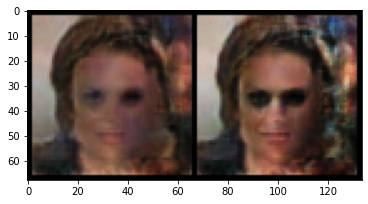

Image LPIPS is 0.16675186157226562


In [ ]:
show_tensor_images(torch.cat([y_1, y_2]))
cur_lpips = loss_fn_vgg(y_1, y_2).item()
print(f"Image LPIPS is {cur_lpips}")

In [ ]:
ppl = cur_lpips / (eps ** 2)
print(f"Our final sample PPL is {ppl}")

Our final sample PPL is 4.16879653930664


In [ ]:
def ppl_w(gen, map_fn, num_samples=10, eps=1e-4):
    """
    Perceptual path length function: Combines the above steps into one PPL function
    """
    # Sample of a batch of num_samples pairs of points
    w_1 = map_fn(torch.randn(num_samples, z_dim))
    w_2 = map_fn(torch.randn(num_samples, z_dim))
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = torch.lerp(w_1, w_2, t)
    interpolated_2 = torch.lerp(w_1, w_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_w: {ppl_w(gen, nn.Identity()).item()}")

PPL_w: 20.581554412841797


In [ ]:
def normalize(x):
    return x / torch.norm(x, dim=1)[:, None]

def get_omega(x, y):
    return torch.acos((normalize(x) * normalize(y)).sum(1))

def slerp(x, y, t):
    omega = get_omega(x, y)[:, None]
    c1 = torch.sin(omega * (1 - t)) / torch.sin(omega)
    c2 = torch.sin(omega * t) / torch.sin(omega)
    return c1 * x + c2 * y

def ppl_z(gen, num_samples=10, eps=1e-4):
    # Sample of a batch of num_samples pairs of points
    z_1 = torch.randn(num_samples, z_dim)
    z_2 = torch.randn(num_samples, z_dim)
    # Sample num_samples points along the interpolated lines
    t = torch.rand(num_samples)[:, None]
    # Interpolate between the points
    interpolated_1 = slerp(z_1, z_2, t)
    interpolated_2 = slerp(z_1, z_2, t + eps)
    # Generated the interpolated images
    y_1, y_2 = gen(interpolated_1), gen(interpolated_2)
    # Calculate the per-sample LPIPS
    cur_lpips = loss_fn_vgg(y_1, y_2)
    # Calculate the PPL from the LPIPS
    ppl = cur_lpips / (eps ** 2)
    return ppl.mean()

print(f"PPL_z: {ppl_z(gen).item()}")

PPL_z: 13.12525749206543
